In [4]:
# Load and review the content of the CSV file to understand its structure and content.
import pandas as pd
from spacy.lang.fr import French
import spacy
import re
import csv
from joblib import Parallel, delayed
import requests


In [ ]:
!python -m spacy download fr_core_news_sm
!pip install joblib
!pip install gender-guesser

# 1. Pre-Process
Preprocess was already done on the dataset


#2. Entity Recognition & Gender Recognition


In [97]:
# Load the CSV file with additional parameters for handling potential errors
data_df = pd.read_csv("data.csv", sep="\t")


In [74]:
# Create a Spacy French language class
nlp = French()

In [ ]:
# not yet data_df['description_cleaned'] = data_df['description_cleaned'].astype(str)

data_df['description'] = data_df['description'].astype(str)
# Load the French NLP model from Spacy
nlp_fr = spacy.load("fr_core_news_sm")

# Function to extract entities and their labels from a text
def extract_entities(text):
    # Process the text with the NLP model
    doc = nlp_fr(text)
    # Extract entities and their labels
    entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['PER']]
    return entities

# Apply the entity extraction to the first few cleaned descriptions
sample_descriptions = data_df['description'] # Using a small sample for demonstration
data_df['entities_in_descriptions'] = sample_descriptions.apply(extract_entities)

# Display the entities extracted from each description
data_df['entities_in_descriptions']


In [98]:
# Load the French NLP model with only the entity recognizer for efficiency
nlp_fr = spacy.load("fr_core_news_sm", disable=["tagger", "parser"])

# Use SpaCy's pipe method for efficient batch processing
texts = data_df['description'].astype(str).tolist()  # Ensure texts are in a list
entities = list(nlp_fr.pipe(texts, batch_size=50, disable=["tagger", "parser"]))  # Adjust batch_size based on your system

# Extract entities and update the DataFrame
data_df['entities_in_descriptions'] = [[(ent.text, ent.label_) for ent in doc.ents if ent.label_ == 'PER'] for doc in entities]

adding the gender prediction to the tuple of NER ...


In [99]:
import gender_guesser.detector as gender

# Create a gender detector
detector = gender.Detector()

# Function to predict gender from first name
def predict_gender(first_name):
    return detector.get_gender(first_name)

# Function to add predicted gender to each tuple
def add_gender_to_tuple(row):
    # Iterate over each tuple in the list
    new_tuples = []
    for name_tuple in row:
        first_name = name_tuple[0].split()[0]  # Extract the first name from the tuple
        predicted_gender = predict_gender(first_name)
        name_tuple_with_gender = (name_tuple[0], name_tuple[1], predicted_gender)
        new_tuples.append(name_tuple_with_gender)
    return new_tuples

# Apply the function to the column containing lists of tuples
data_df['entities_in_descriptions'] = data_df['entities_in_descriptions'].apply(add_gender_to_tuple)

# Print the first few rows to see the results
print(data_df['entities_in_descriptions'].head())


0                                                   []
1                                                   []
2                               [(Man\, PER, unknown)]
3    [(François Hollande, PER, male), (Manuel Valls...
4    [(David DOUKHAN, PER, male), (Daniel LEVY, PER...
Name: entities_in_descriptions, dtype: object


In [100]:
# to get the presentor gender

# Create a gender detector
detector = gender.Detector()

# Function to predict gender from first name
def predict_gender(first_name):
    return detector.get_gender(first_name.split()[0])  # Split the name and take the first part if it's full name

# Apply the function to the 'presenter' column to create a new 'gender' column
data_df['gender'] = data_df['presenter'].apply(predict_gender)

# Print the first few rows to see the results
print(data_df[['presenter', 'gender']].head())


            presenter  gender
0  Laurent Delahousse    male
1         Elise Lucet  female
2       David Pujadas    male
3       David Pujadas    male
4  Laurent Delahousse    male


Index(['title', 'description', 'date', 'order', 'presenter', 'editor', 'url',
       'urlTvNews', 'containsWordGlobalWarming', 'media', 'month', 'day',
       'entities_in_descriptions', 'gender'],
      dtype='object')

In [102]:
import pandas as pd

# Function to calculate gender counts from tuples in 'entities_in_descriptions'
def count_genders_from_tuples(entities_list):
    gender_counts = {'male': 0, 'female': 0}
    for entity in entities_list:
        if entity[2] == 'male':  # Assuming the gender is the third element in the tuple
            gender_counts['male'] += 1
        elif entity[2] == 'female':
            gender_counts['female'] += 1
    return gender_counts

# Calculate counts for 'presenter' column
presenter_genders = data_df['gender'].value_counts().to_dict()

# Apply the function and calculate counts for 'entities_in_descriptions' column
entities_genders = data_df['entities_in_descriptions'].apply(count_genders_from_tuples)

# Convert list of dictionaries to a DataFrame
entities_genders_df = pd.DataFrame(list(entities_genders)).fillna(0)

# Sum gender counts across all rows
entities_genders_sum = entities_genders_df.sum().to_dict()  # Correctly sum across rows for each gender

# Combine counts from both columns
total_male = presenter_genders.get('male', 0) + entities_genders_sum.get('male', 0)
total_female = presenter_genders.get('female', 0) + entities_genders_sum.get('female', 0)

# Calculate Gender Parity Index for the dataset
gpi = total_female / total_male if total_male > 0 else 0  # Avoid division by zero

# Print out the GPI
print(f"Gender Parity Index (GPI) for the dataset is: {gpi}")



Gender Parity Index (GPI) for the dataset is: 0.49202250910294604


In [103]:
# Function to calculate GPI from tuples in 'entities_in_descriptions' for each article
def calculate_gpi_for_article(entities_list):
    gender_counts = {'male': 0, 'female': 0}
    for entity in entities_list:
        if entity[2] == 'male':
            gender_counts['male'] += 1
        elif entity[2] == 'female':
            gender_counts['female'] += 1
    # Calculate GPI for the article, avoiding division by zero
    gpi = gender_counts['female'] / gender_counts['male'] if gender_counts['male'] > 0 else 0
    return gpi

# Apply the function to each article and store results in a new 'gpi' column
data_df['gpi'] = data_df['entities_in_descriptions'].apply(calculate_gpi_for_article)

# Now, your DataFrame has a new column 'gpi' that contains the Gender Parity Index for each article
print(data_df[['gpi']].head())  # Print the first few GPI values to see the results


    gpi
0  0.00
1  0.00
2  0.00
3  0.25
4  0.00


In [105]:
# Function to calculate adjusted GPI from tuples in 'entities_in_descriptions' for each article
def calculate_adjusted_gpi_for_article(entities_list):
    gender_counts = {'male': 0, 'female': 0}
    for entity in entities_list:
        if entity[2] == 'male':
            gender_counts['male'] += 1
        elif entity[2] == 'female':
            gender_counts['female'] += 1
    total_individuals = gender_counts['male'] + gender_counts['female']
    # Calculate adjusted GPI for the article, avoiding division by zero
    adjusted_gpi = (gender_counts['female'] - gender_counts['male']) / total_individuals if total_individuals > 0 else 0
    return adjusted_gpi

# Apply the function to each article and store results in a new 'adjusted_gpi' column
data_df['adjusted_gpi'] = data_df['entities_in_descriptions'].apply(calculate_adjusted_gpi_for_article)

# Now, your DataFrame has a new column 'adjusted_gpi' that contains the adjusted Gender Parity Index for each article
print(data_df[['adjusted_gpi']].head())  # Print the first few adjusted GPI values to see the results


   adjusted_gpi
0           0.0
1           0.0
2           0.0
3          -0.6
4          -1.0


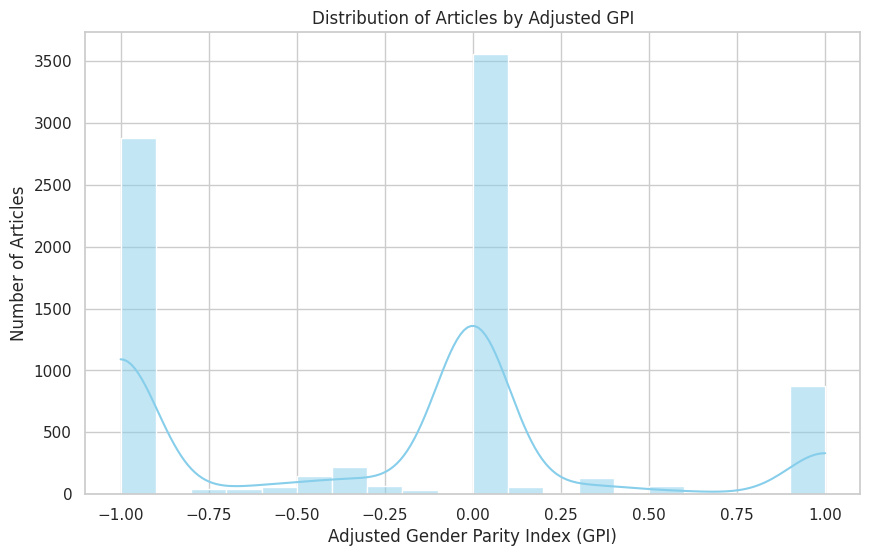

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a histogram for the distribution of the adjusted GPI
plt.figure(figsize=(10, 6))
sns.histplot(data=data_df, x='adjusted_gpi', bins=20, kde=True, color='skyblue')

# Enhance plot
plt.title('Distribution of Articles by Adjusted GPI')
plt.xlabel('Adjusted Gender Parity Index (GPI)')
plt.ylabel('Number of Articles')

# Show plot
plt.show()

In [111]:
data_df['media'].unique()

array(['France 2'], dtype=object)

<ipython-input-112-7211ee2a5a1e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=data_df, x='media', y='adjusted_gpi', jitter=True, size=6, palette='Set1', dodge=True)


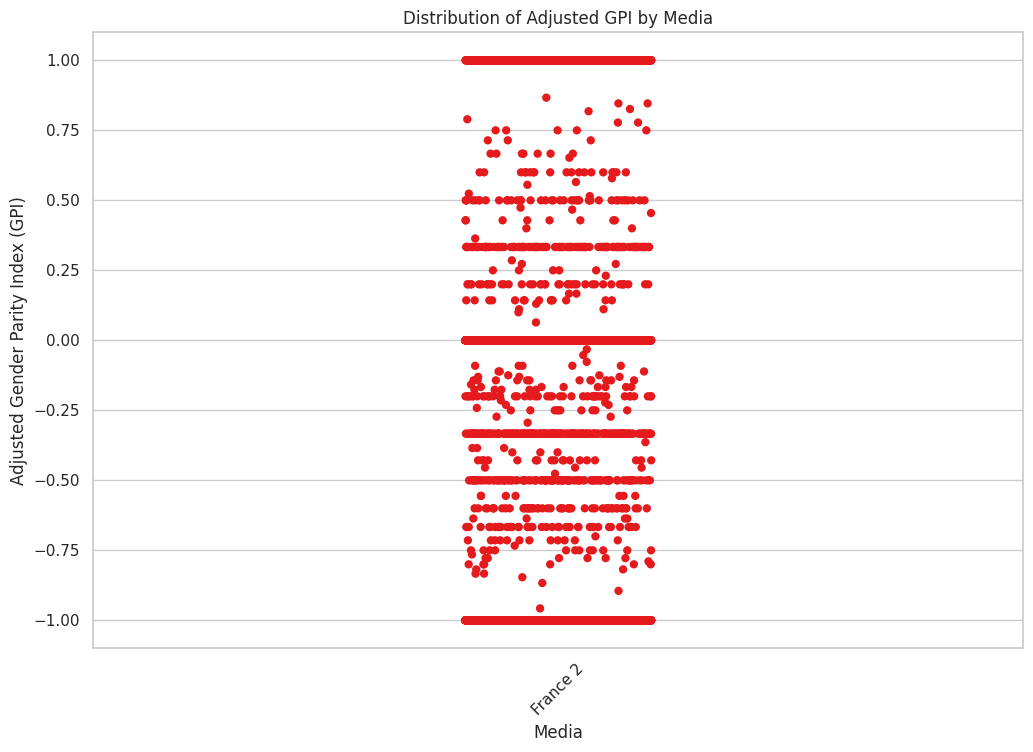

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")


# Now, let's try creating the scatter plot again
plt.figure(figsize=(12, 8))
sns.stripplot(data=data_df, x='media', y='adjusted_gpi', jitter=True, size=6, palette='Set1', dodge=True)

# Enhance plot
plt.title('Distribution of Adjusted GPI by Media')
plt.xlabel('Media')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.ylabel('Adjusted Gender Parity Index (GPI)')

# Show plot
plt.show()


In [115]:
data_df.to_csv("gpi_data.csv")
data_df

,title,description,date,order,presenter,editor,url,urlTvNews,containsWordGlobalWarming,media,month,day,entities_in_descriptions,gender,gpi,adjusted_gpi
0,NaN,NaN,2013-11-02T00:00:00.000Z,21,Laurent Delahousse,NaN,https://www.francetvinfo.fr/sujet_449888.html,https://www.francetvinfo.fr/replay-jt/france-2...,False,France 2,11,2,[],male,0.00,0.0
1,"\Cash Investigation\"" ce soir à 22h30""",On avait parlé de l'évasion fiscale des multin...,2013-09-18T00:00:00.000Z,10,Elise Lucet,NaN,https://www.francetvinfo.fr/cash-investigation...,https://www.francetvinfo.fr/replay-jt/france-2...,False,France 2,9,18,[],female,0.00,0.0
2,"\Elle Man\"", nouveau magazine en kiosque""",Voici leurs portraits. Nous ne les oublions pa...,2013-10-02T00:00:00.000Z,22,David Pujadas,NaN,https://www.francetvinfo.fr/elle-man-nouveau-m...,https://www.francetvinfo.fr/replay-jt/france-2...,False,France 2,10,2,"[(Man\, PER, unknown)]",male,0.00,0.0
3,11 novembre : incidents pendant les commémorat...,"Autre titre, les cérémonies du 1. Novembre. On...",2013-11-11T00:00:00.000Z,9,David Pujadas,NaN,https://www.francetvinfo.fr/11-novembre-incide...,https://www.francetvinfo.fr/replay-jt/france-2...,False,France 2,11,11,"[(François Hollande, PER, male), (Manuel Valls...",male,0.25,-0.6
4,132 millions d'euros : coût et rapport,"132 millions d'euros, c'est bien sûr un gain q...",2013-03-29T23:00:00.000Z,6,Laurent Delahousse,NaN,https://www.francetvinfo.fr/132-millions-d-eur...,https://www.francetvinfo.fr/replay-jt/france-2...,False,France 2,3,29,"[(David DOUKHAN, PER, male), (Daniel LEVY, PER...",male,0.00,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8219,À SUIVRE : * L. Neuwirth * Pêcheurs * Graisses...,"Restez avec nous, à suivre. Le gaulliste Lucie...",2013-11-26T00:00:00.000Z,11,David Pujadas,NaN,https://www.francetvinfo.fr/a-suivre-l-neuwirt...,https://www.francetvinfo.fr/replay-jt/france-2...,False,France 2,11,26,"[(Lucien Neuwirth, PER, male)]",male,0.00,-1.0
8220,À SUIVRE :* Champignons* Sports week-end* Tran...,A suivre dans un instant. Une leçon de cuisine...,2013-10-19T00:00:00.000Z,15,Laurent Delahousse,NaN,https://www.francetvinfo.fr/a-suivre-champigno...,https://www.francetvinfo.fr/replay-jt/france-2...,False,France 2,10,19,"[(Zlatan Ibrahimovic, PER, male), (Arturo Brac...",male,0.00,-1.0
8221,À SUIVRE :* Fukushima* Aigle* Séparation,Il y a une inversion de la courbe du chômage C...,2013-09-24T00:00:00.000Z,13,David Pujadas,NaN,https://www.francetvinfo.fr/a-suivre-fukushima...,https://www.francetvinfo.fr/replay-jt/france-2...,False,France 2,9,24,[],male,0.00,0.0
8222,À SUIVRE :* Sans pilote* Sourire* L'Appel,A suivre dans ce journal : Il n'y a plus de pi...,2013-06-18T00:00:00.000Z,15,David Pujadas,NaN,https://www.francetvinfo.fr/a-suivre-sans-pilo...,https://www.francetvinfo.fr/replay-jt/france-2...,False,France 2,6,18,[],male,0.00,0.0
